<a href="https://colab.research.google.com/github/JunjieLiang-Jack/Audio-Classifier/blob/main/3_cnn_model_mfcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Classifying audio data with convolutional neural networks

<br/>
by Eduardo Garcia Rajo<br/>
<br/>

This notebook is part of the project "Urban sounds classification with Covnolutional Neural Networks" on [my Github](https://github.com/GorillaBus/urban-audio-classifier).<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

# Basic CNN Model - MFCC

In this notebook I want to build simple yet effective convolutional model to solve a multi-class classification problem. I would also like to understand how the model performs for the different classes by the use of statistical tools that are not integrated in the Keras/TensorFlow packages but come by the hand of a very popular library in the field of data science with Python which is the Sci-Kit Learn package.<br/>
<br/>
As the title points out, I'm going to work with MFCC features (and I will replicate this notebook with Log-Mel Spectrograms on the next notebook to compare results).<br/>
Along the way I'm going to put a big effort in describing the reasons why I implement different techniques/methods and how I obtained my results.<br/>
<br/>

INDEX

1. Data preparation: features + metadata
2. Basic CNN model
3. Model evaluation
4. Exploring the misclassified
5. Conclusion
6. Next


<br/>
<br/>

#### * Load required libraries

In [ ]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/GorillaBus/urban-audio-classifier.git


import random
from datetime import datetime

sys.path.insert(0,'/content/urban-audio-classifier/include')
import helpers

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


Mounted at /content/drive
Cloning into 'urban-audio-classifier'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 371 (delta 33), reused 37 (delta 11), pack-reused 305
Receiving objects: 100% (371/371), 86.47 MiB | 28.88 MiB/s, done.
Resolving deltas: 100% (153/153), done.


#### * Setup

In [ ]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('drive/MyDrive/CNN/Training Data/UrbanSound8K/')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [ ]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.compat.v1.Session(config=config))

#### * Load MFCC data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with 40 MFCC coefficients and 174 frames. Each feature was zero-centered and scaled between -1 and 1 during extraction.<br/>
<br/>

In [ ]:
# Pre-processed MFCC coefficients
X = np.load("drive/MyDrive/CNN/Training Data/UrbanSound8K/data/mfcc/X-mfcc.npy")
y = np.load("drive/MyDrive/CNN/Training Data/UrbanSound8K/data/mfcc/y-mfcc.npy")

# Metadata
metadata = pd.read_csv(metadata_path)

### 1. Data preparation: features + metadata

#### 1.1 Train / Test split

Note that we are using the same index order for both the MFCC arrays and the metadata to keep track of the origin of each feature.<br/>
<br/>

In [ ]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


#### 1.2 One hot encode labels

In [ ]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [ ]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

#### 1.4 Considerations

In Notebook #1 we took a look at the class balance of our dataset:<br/>
    
    * jackhammer          1000
    * air_conditioner     1000
    * dog_bark            1000
    * engine_idling       1000
    * street_music        1000
    * children_playing    1000
    * drilling            1000
    * siren                929
    * car_horn             429
    * gun_shot             374

A common problem in multi-class classification comes from imbalanced datasets where the classifier tends to learn more about classes that contain more samples, as a result the classes with less samples are predicted with more error and less accuracy. Normally, this occurs when the difference ratio is large enough. In our case we have two classes that contain much less occurrences: if the model shows difficulty on this classes we can try using class weights. We'll analyze this after training checking precision, recall and f1 scores.<br/>
<br/>

## 2. Basic CNN model

In this first approach I started from the simplest possible CNN model: only one hidden convolutional layer, no regularization, no downsampling, no fully connected layers. I started adding complexity once it overfitted the train data, obtaining the current model architecture, which is yet a very simple combination of two convolutional blocks, downsampling and regularization.<br/>
<br/>
The first convolutional block will learn lower-level features. The second block will downsample the data reducing it's spatiality to it's half, therefore, the third block  will be able to learn patterns of smaller scale or higher-level features (note the filter sizes are still 3x3, but the dimensions of the plane have changed).<br/>
Combining convolutional layers with max pooling is a commonly used technique, in fact what I'm doing here is replicating a basic building block of a ResNet architecture.<br/>
Regularization has been added once the model showed overfitting. The main regularization type I'm using is **Spatial Dropout**, which will drop complete filters by a certain rate to force the network to update others. This type of dropout is much more sensible than normal dropout. Note that as layer capacity increases, we also increase the Spatial Dropout rate as with more filters we need higher drop frequency.<br/>
**L2** regularization was also added by a slight value. When using **L2** we introduce a constraint to which the optimizer has to bond so that no weight can be updated by a value outside this constraint.<br/>

#### Model architecture:
<br/>
    
    Segment #1
    -
    Convolution (32 filters, 3x3 size)
    BatchNormalization
    SpatialDropout (0.07)
    Convolution (32 filters, 3x3 size)
    BatchNormalization    
    -
    Segment #2
    -
    MaxPooling(2x2)
    -
    Segment #3
    -
    SpatialDropout (0.07)
    Convolution (64 filters, 3x3 size)
    BatchNormalization
    SpatialDropout (0.14)
    Convolution (64 filters, 3x3 size)
    BatchNormalization
    -
    Segment #4
    -
    GlobalAveragePooling2D
    -
    Segment #5
    -
    Dense 10 units (Softwmax output)
    
<br/>

#### Building blocks reference:

If you are already experienced with neural networks and convolutions you may want to skip the details. In other case, here is a detailed description of the building blocks:<br/>
<br/>

1. **Convolutional layers and filter amounts:** each convolutional layer will learn different features from the training data. The first layers will always learn more low level features (like lines and dots on an image, for example), while the following layers will learn more high-level patterns (basic shapes). The more complex the data is in means of patterns, the more convolutional layers that will be required learn them.<br/>On the other hand, there will always be less low-level patterns and more high-level patters (formed by combinations of those lower level patterns), that's why we keep increasing the amount of filters as we add convolutional layers to the network.

2. **Kernel sizes**: I'm using one 5x5 and 3x3 kernel sizes as the smallest size that worked out on my experiments. I also tested 7x7 -as saw on some image classifiers- but they didn't work well with this data. Also notice I use odd numbers for kernel sizes, this is a very important rule and [here is an excellent explanation](https://datascience.stackexchange.com/questions/23183/why-convolutions-always-use-odd-numbers-as-filter-size) Stackoverflow.

3. **Batch normalization**: In short, it normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This process optimizes training time. There is a [friendly introduction to batch normalization](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c) .

4. **MaxPooling**: a common technique to downsample our data reducing dimensionality, if not familiarized have a look at [this article](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) from computersciencewiki.org.

5. **Spatial dropout**: A regularization method that works like the [standard dropout](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) used in neural networks, that applies better for convolutional layers: it works by dropping out entire feature maps by a given rate, preventing activations from becoming strongly correlated. It's effect is usually more sensible than the standard dropout and as you may have advertised I'm increasing the rate as I add new layers, this is a common practice as higher level layers are also containing more filters. Another important advice is to use it after max pooling.

6. **GlobalAveragePooling**: until some years ago it was mostly common to see CNN architectures that would flatten out the output from the last convolutional layer to connect it to a series of dense layers that would "interprete" and make category predictions. Today is more common to see this dense layers replaced with a Global Average Pooling layer that calculates the average output of each feature map in the previous layer, strongly reducing dimensionality. This demonstrated to work better in many scenarios, also being much more computationally cheap. Read more in [this article](https://principlesofdeeplearning.com/index.php/a-tutorial-on-global-average-pooling/).

7. **Dense (softmax output)**: the final layer containing the softmax output that will provide the classification probabilities for the input data.<br/>
<br/>

#### 2.1 Model definition



In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

#### 2.2 Setup model optimizer and loss function

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters to start from somewhere, then reduced learning rate to 1e-4 (as loss history was noisy).
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#### 2.3 Training the model

Note we use a portion of the train set as a validation set.

In [ ]:
num_epochs = 250
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
51/51 [==============================] - 187s 3s/step - loss: 2.2239 - accuracy: 0.2077 - val_loss: 2.3785 - val_accuracy: 0.1338

Epoch 00001: val_loss improved from inf to 2.37848, saving model to /content/models/simple-train-nb3.hdf5
Epoch 2/250
51/51 [==============================] - 167s 3s/step - loss: 1.9553 - accuracy: 0.3359 - val_loss: 2.4184 - val_accuracy: 0.1372

Epoch 00002: val_loss did not improve from 2.37848
Epoch 3/250
51/51 [==============================] - 167s 3s/step - loss: 1.8062 - accuracy: 0.3846 - val_loss: 2.5417 - val_accuracy: 0.1201

Epoch 00003: val_loss did not improve from 2.37848
Epoch 4/250
51/51 [==============================] - 167s 3s/step - loss: 1.7391 - accuracy: 0.3972 - val_loss: 2.6904 - val_accuracy: 0.1424

Epoch 00004: val_loss did not improve from 2.37848
Epoch 5/250
51/51 [==============================] - 167s 3s/step - loss: 1.6975 - accuracy: 0.4170 - val_loss: 2.9174 - val_accuracy: 0.1389

Epoch 00005: val_loss did 

In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/models/simple-train-nb3.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_images, 
          train_labels,
          epochs=50, 
          batch_size=batch_size, 
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)

#### 2.4 General model evaluation
We first load the checkpoint with the lowest validation loss achieved during training. We then use the Test set to evaluate the model with data that has not been seen by the model nor by me when tuning hyper-parameters.

In [ ]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

NameError: ignored

The error difference between Train and Test is small. To measure this different I'm using **the normalized difference between Train and Test error**, I report this as **norm diff** and show it as a percentage. If this difference is somewhere around 3.5% I will estimate the model is not overfitting. If it's negative, it will most probably be underfit.<br/>
<br/>
Train and test loss scores are similar and so the accuracy, with a normal diff of 3.8%, acceptable, but also just about to start overfitting as this amount of loss difference is hardly recoverable with more training.<br/>
With **89.69%** test accuracy we are over the mean score achieved by previous works on this dataset using MFCC features and CNN networks.<br/>
<br/>

#### 2.5 Train vs Test history plot

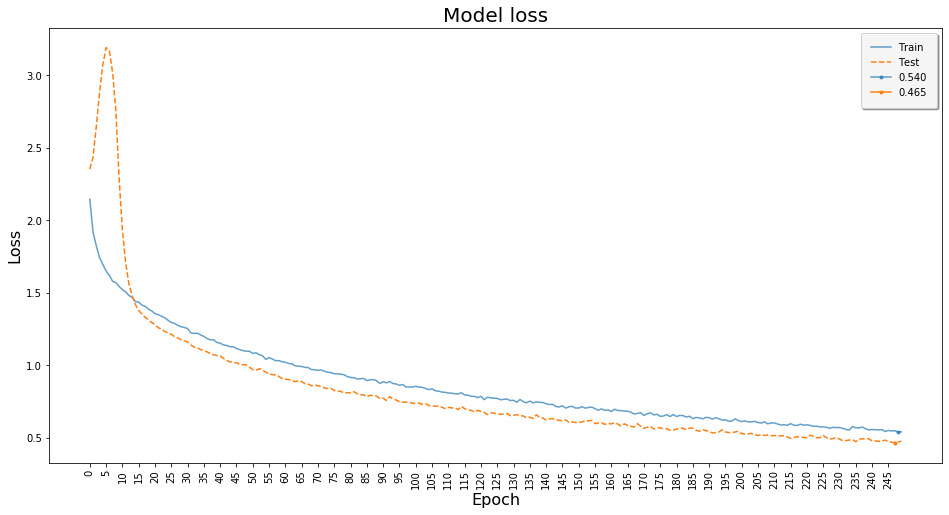

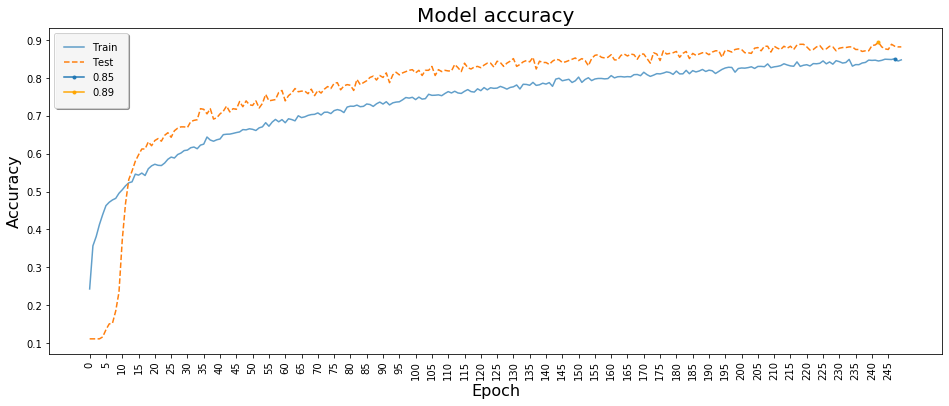

In [ ]:
helpers.plot_train_history(history, x_ticks_vertical=True)

The generalization gap in the plot is quite smooth, which is a good sign. We could use a larger batch size and a smoother curve -as the direction of the gradient would be more certain-, but on my test it tended much more to overfit with **256** than **128**. Lower batch size values will add some kind of regularization factor to training -because the direction of the gradient becomes less certain-.<br/>
<br/>
Note that test error is lower than train error: this normal as during training the error is calculated while the model is using dropout (what adds more difficulty).<br/>
<br/>


### 3. Model evaluation
Now let's see how the model performs predicting the different classes using data from the test set, data that has not been used to train the model.<br/>
<br/>

#### * Register model output

In [ ]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

/home/edu/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


#### 3.1 Confussion matrix

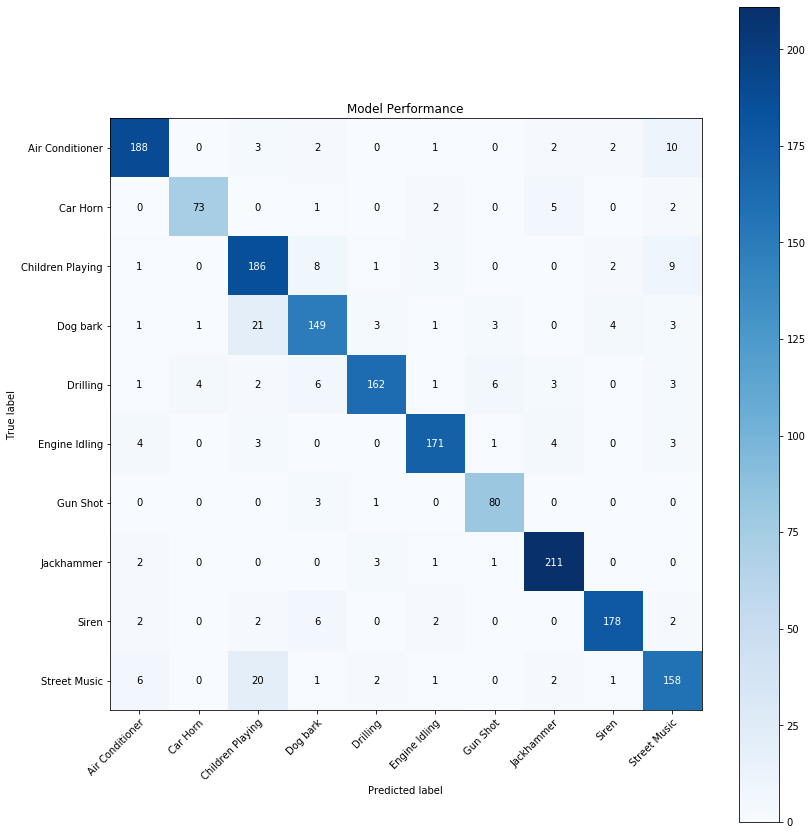

In [ ]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

 
The most noticeable error is confusing **Street music** with **Children playing**. We'll see later on that this two classes will share similar patterns like street ambient sound and people talking in the background.<br/>
Another case is **Children Playing** as **Dog Bark** and viceversa, and we'll discover exploring the dataset that there are children playing samples that include events of dogs barking.<br/>
**Drilling** and **Jack hammer** both share a similar sound dynamics pattern audible as change in amplitude in a constant frequency, usually with different pitches for one and the other.<br/>
Between **Gunshot** and **Dog bark**, as pointed out by the confusion matrix results.<br/>
<br/>

#### 3.2 Accuracy table

In [ ]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

CLASS   ACCURACY
7        Jackhammer  96.788991
6          Gun Shot  95.238095
8             Siren  92.708333
5     Engine Idling  91.935484
0   Air Conditioner  90.384615
2  Children Playing  88.571429
1          Car Horn  87.951807
4          Drilling  86.170213
9      Street Music  82.722513
3          Dog bark  80.107527

#### 3.3 Classification performance: Presicion, Recall and F1 scores



In [ ]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.92      0.90      0.91       208
        Car Horn       0.94      0.88      0.91        83
Children Playing       0.78      0.89      0.83       210
        Dog bark       0.85      0.80      0.82       186
        Drilling       0.94      0.86      0.90       188
   Engine Idling       0.93      0.92      0.93       186
        Gun Shot       0.88      0.95      0.91        84
      Jackhammer       0.93      0.97      0.95       218
           Siren       0.95      0.93      0.94       192
    Street Music       0.83      0.83      0.83       191

        accuracy                           0.89      1746
       macro avg       0.90      0.89      0.89      1746
    weighted avg       0.89      0.89      0.89      1746



**Street music** got the lowest Recall score: as we expected for what we saw on the confusion matrix where many class occurrences where classified as **Children Playing** (false negatives). Similarly, we see that many times some other class was classified as Street Music (false positive), what also lowers the Precision score for this class.<br/>
<br/>
We can identify something similar with **Gunshot** -an unbalanced class-, where we have the lowest precision score, and if you observe the confusion matrix on the vertical axis, the model identified many other classes as Gunshot (false positives). Quite the opposite occurs on the horizontal axis: we have very little false negatives and a good Recall score for this class.<br/>
<br/>
The other unbalanced class **Car Horn** has acceptable F1 score, just around the average, but it's a bit low in recall, again, as observed on the horizontal axis of the confusion matrix.<br/>
<br/>
In general, and although we have a  we can say the model is quite capable of recognizing relevant data.<br/>
<br/>

### 4. Exploring the misclassified

Warning: this is not a statistical analysis. The idea is to make some intuitions about why some samples where misclassified. We talked about similar patterns between some special classes, so, let's "see" if we can identify some of this patterns to make some more sense of what model is doing.<br/>
<br/>
**Note** that results may vary between different training sessions because of the stochastic nature of the training process. The presented results are likely be generic, but are still bound to the training session registered by this notebook.<br/>
<br/>

#### 4.1 Street music as Children playing 

In [ ]:
# Find the target misclassified ocurrencies
street_as_children = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 2)]

files = []
for idx, row in street_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [ ]:
print("Children playing as Street music: {} ocurrencies".format(len(street_as_children)))

# Manully set the file index
index = 12
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Children playing as Street music: 16 ocurrencies

True category: street_music
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold4/76568-9-0-2.wav


#### Observations

* In many cases the samples are clear, with foreground music and very little noise
* Many occurrences with people talking in foreground (as it happens many times with Children Playing samples)
* Multiple cases where you barely distinguish music at the background and heavy ambiance noise

<br/>
<br/>

#### 4.2 Drilling as Jack Hammer

In [ ]:
# Find the target misclassified ocurrencies
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]
files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)


In [ ]:
print("Drilling as Jack Hammer: {} ocurrencies".format(len(drilling_as_jack)))

# Manully set the file index
index = 3
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Drilling as Jack Hammer: 5 ocurrencies

True category: drilling
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold9/180937-4-1-27.wav


#### Observations

Although this are very similar classes, there are some key differences like the pitch and I would also say the amplitude dynamics, while drillers sound treble and with a more constant amplitude, jack hammers sound more mid-low with a much clear percussive pattern.<br/>

* Many occurrences are drillers that sound really bass and percussive, even a human would confuse it
* Some occurrences do sound like a driller

<br/>
<br/>

#### 4.3 Dog Bark as Children Playing

In [ ]:
# Drilling as Air Conditioner
dogbar_as_children = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 2)]

files = []
for idx, row in dogbar_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [ ]:
print("Dog Bark as Children Playing: {} ocurrencies".format(len(dogbar_as_children)))
    
# Manully set the file index
index = 8
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Dog Bark as Children Playing: 18 ocurrencies

True category: dog_bark
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold5/76566-3-0-6.wav


#### Observations

* There are cases where a dog bark sound can be identified, but also children playing in foreground
* In many cases the dog bark sound is mixed up with high ambiance sound and/or people talking
* There are also very clear samples of dog bark that have not been identified

<br/>
<br/>

#### 4.4 Street Music as Air Conditioner

In [ ]:
# Street Music as Air Conditioner
music_as_aircon = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 0)]

files = []
for idx, row in music_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [ ]:
print("Street Music as Air Conditioner: {} ocurrencies".format(len(music_as_aircon)))

# Manully set the file index
index = 2
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

IPython.display.Audio(files[index])

Street Music as Air Conditioner: 8 ocurrencies

True category: street_music
File: /home/edu/Projects/urban-audio-classifier/UrbanSound8K/audio/fold5/155243-9-0-55.wav


#### Observations

* Despite of some very clear misclassification examples, there are many cases where the street music sounds very weakly in the background while, at the same time, there is much continuous noise in the mid-to-low frequencies.

* Street ambiance sound seems to be a common factor in the two classes, the model seems to fail distinguishing the most essential patterns that describe each of this two classes.
<br/>
<br/>

### 5. Conclusions

<br/>
There are clear signs of bad classification performance when the objective sound is not loud enough or when it competes strongly with other sound sources in the audio sample. The fact that this occurs very often in this dataset makes it difficult to distinguish between some classes -this maybe the reason why more scientific researches with this dataset  achieved similar accuracy than what we got (unfortunately they don't show a classification performance report to compare).<br/>

Once the model reached ~85% of general accuracy it starts to overfit, no matter how much regularization I added. I have tried many things like using different normalization methods, no normalization, using different MFCC extracting methods, more MFCC bands (up to 128) and even working with Mel Spectrograms of 128 MFCC bands, nothing worked. If there is a way to get above this scores I think it would be using a more complex model like ResNets, with which more layers could be used without degradation.<br/>

<br/>
In general, and compared to other works I have found with this same dataset, we achieved some acceptable results and a piece of work to start experimenting with tweaking and optimizing once we develop some hypothesis about what the model maybe doing wrong and how can we do it better.<br/>
<br/> 

### 6. Next

As I said I'd like to compare results between MFCC and Log-Mel Spectrogram features. On the next notebook I'm going to use this same approach and see how the results compare.<br/>
<br/>
<br/>